# Praca Domowa 2

Indywidualnie, zaimplementować model konwolucyjnej sieci neuronowej (CNN) do klasyfikacji w `torch` i przetestować go na **wybranym zbiorze danych**. Powstały raport w formatach `.ipynb` oraz `.html` powinien zawierać wnioski z przeprowadzonej analizy.
1. ~~1 punkt uzyskuje się za pracę z zbiorem danych [CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)  (60k [take a subset: 1/3-1/2], 10 classes, 32x32 images)~~
2. 2 punkty uzyskuje się za pracę z zbiorem danych [OxfordIIITPet](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html)  (7.4k, 37 classes, varied sizes of images)
3. 3 punkty uzyskuje się za pracę z zbiorem danych [StanfordCars](https://pytorch.org/vision/main/generated/torchvision.datasets.StanfordCars.html) (17k [if too large, take a subset], 196 classes, 360×240 images)

- ~~do 2 punktów uzyskuje się za wytrenowanie skutecznego modelu ResNet (porównać dwie wielkości, np. 18 i 34, na zbiorze treningowym i testowym)~~
- ~~1 punkt uzyskuje się za zaprezentowanie zwalczania zjawiska przeuczenia wykorzystując Dropout (lub inny sposób regularyzacji)~~
- ~~1 punkt uzyskuje się za zwizualizowanie macierzy konfuzji ORAZ pokazanie ozasadnionych/ciekawych przykłady obrazów, na których model się mylił~~
- ~~1 punkt uzyskuje się za zwizualizowanie wektora reprezentacji obrazów w podziale na klasy (kolor), wykorzystując PCA/TSNE (lub inny algorytm redukcji wymiaru)~~
- do 2 punktów uzyskuje sie za jakość raportu (opisu, wizualizacji, kodu), a w szczególności *agregację wyników* w postaci tabel lub/i wykresów.

**Uwaga!** (1) Zabronione jest importowanie modeli z bibliotek; można korzystać z repozytoriów takich jak https://github.com/kuangliu/pytorch-cifar. (2) Warto zacząć od uczenia sieci na podzbiorze, np. 10%, danych treningowych (i ewaluowania na podzbiorze danych testowych) dla zaoszczędzenia czasu. 

Praca domowa jest na 8 punktów (można uzyskać max 10 punktów).

Deadline: 30 marca 23:59. Na zajęciach 31 marca 5 wybranch osób krótko zaprezentuje swoje wyniki.

Pracę zgłaszamy poprzez PR o tytule `[PD2] Imię Nazwisko` do folderu `homeworks/pd2/imię_nazwisko`.

# Wizualizacja wektora reprezentacji obrazów

Przykład: https://medium.com/@pslinge144/representation-learning-cifar-10-23b0d9833c40

In [32]:
!pip install captum
import captum
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu" 

# Downloading CIFAR10

In [33]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10/train',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

# Use standard FashionMNIST dataset
test_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10/test',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
mask = [i for i in range(round(len(train_set.data)/10))]
train_set_small = torch.utils.data.Subset(train_set, mask)
test_set_small =  torch.utils.data.Subset(test_set, mask)

# Resnet from Github

Source: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

Copied the whole script from the link suggested in the task description

In [35]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

#test()

# Model creation

## Hyperparameters search functions

### RunBuilder

Copied from labs.

In [36]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images.to(DEVICE))

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.to(DEVICE))

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

    self.epoch_loss_test = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    self.tb.add_scalar('Accuracy_test', accuracy_test, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

### Searching function

Runs RunBuilder with given parameters.

In [37]:
def searching_function(params2, output_name,model, return_model=False, use_all_data=False):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params2):
    
    # if params changes, following line of code should reflect the changes too
    network = model().to(DEVICE)
    if use_all_data == True:
      loader_test = torch.utils.data.DataLoader(test_set, batch_size = run.batch_size,num_workers=2)
      loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size,num_workers=2)
    else: 
      loader_test = torch.utils.data.DataLoader(test_set_small, batch_size = run.batch_size,num_workers=2)
      loader = torch.utils.data.DataLoader(train_set_small, batch_size = run.batch_size,num_workers=2)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    

    m.begin_run(run, network, loader, loader_test)
    for epoch in range(epochs):
      
      m.begin_epoch()
      
      for batch in loader_test:

        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        m.track_num_correct_test(preds, labels)


      for batch in loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

    # when all runs are done, save results to files
    m.save(output_name)
    if return_model == True:
      return network

## Let the search begin

In [43]:
from collections  import OrderedDict
params = OrderedDict(
    lr = [.01,0.001],
    batch_size = [10,100],
    shuffle = [True],
)
epochs = 3

In [ ]:
searching_function(params, 'results18', model=ResNet18)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.308736,0.1832,0.0984,42.392180,43.131065,0.010,10,True
1,1,2,1.909859,0.2892,0.2124,43.309311,89.569302,0.010,10,True
2,1,3,1.733857,0.3586,0.3312,44.429420,136.704627,0.010,10,True
3,2,1,2.481764,0.1866,0.1090,20.210294,21.316529,0.010,100,True
4,2,2,1.969036,0.2650,0.2540,20.158232,44.261716,0.010,100,True
5,2,3,1.827545,0.3188,0.2848,20.216914,67.173519,0.010,100,True
6,3,1,2.008006,0.2702,0.0872,42.606489,43.309389,0.001,10,True
7,3,2,1.737701,0.3552,0.3208,42.566914,88.615072,0.001,10,True
8,3,3,1.579897,0.4154,0.3566,42.413213,133.635201,0.001,10,True
9,4,1,1.866153,0.3158,0.1134,20.145049,21.230039,0.001,100,True


In [ ]:
searching_function(params, 'results34',model=ResNet34)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.328046,0.1586,0.0994,77.619079,78.698993,0.010,10,True
1,1,2,2.081061,0.2092,0.1876,77.699874,161.336027,0.010,10,True
2,1,3,1.978568,0.2510,0.2328,77.644915,243.976074,0.010,10,True
3,2,1,2.759419,0.1366,0.0950,32.400956,33.975502,0.010,100,True
4,2,2,2.109853,0.2128,0.1740,32.383622,71.528816,0.010,100,True
5,2,3,1.915034,0.2802,0.2400,32.441569,109.127726,0.010,100,True
6,3,1,2.114901,0.2418,0.1012,77.810025,78.838739,0.001,10,True
7,3,2,1.856476,0.3192,0.3232,77.750408,161.758051,0.001,10,True
8,3,3,1.724797,0.3716,0.3424,77.849703,244.730547,0.001,10,True
9,4,1,2.053587,0.2706,0.1010,32.542716,34.110325,0.001,100,True


Seems that when the batch size was bigger, the training was faster in terms of accuracy on 10% subset of test data. Also duration of epochs is shorter. Learning rate set at 0.001 looks ok.

# Comparing Restnet18 and ResNet34

Let's see the performance of ResNet18 vs ResNet34 after training for a few more epochs on all data. It's worth noting that the larger network (ResNet34) requires more epochs as it is learning slower than the smaller network. However due to using the whole dataset and to shorten the total time spent training, both models will have around 20 minutes.

In [ ]:
params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    shuffle = [True],
)
epochs = 10

In [ ]:
res18 = searching_function(params, 'results18', model=ResNet18, return_model=True, use_all_data=True)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.736884,0.37610,0.1051,136.224639,146.235877,0.001,1000,True
1,1,2,1.219351,0.55466,0.4896,135.113725,284.027412,0.001,1000,True
2,1,3,0.948740,0.66124,0.6029,134.814551,421.607157,0.001,1000,True
3,1,4,0.763303,0.72848,0.6878,134.942417,559.353577,0.001,1000,True
4,1,5,0.615977,0.78286,0.7292,134.913615,696.933199,0.001,1000,True
5,1,6,0.496865,0.82742,0.7615,134.595084,834.313036,0.001,1000,True
6,1,7,0.428936,0.85002,0.7759,134.718137,971.807327,0.001,1000,True
7,1,8,0.363913,0.87300,0.7942,134.776696,1109.416321,0.001,1000,True
8,1,9,0.308369,0.89158,0.7843,134.768081,1246.918661,0.001,1000,True
9,1,10,0.232290,0.91940,0.8010,134.592370,1384.220263,0.001,1000,True


In [ ]:
params = OrderedDict(
    lr = [0.001],
    batch_size = [600],
    shuffle = [True],
)
epochs = 5

In [ ]:
res34 = searching_function(params, 'results34',model=ResNet34, return_model=True, use_all_data=True)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.716405,0.37662,0.1049,224.829064,233.920234,0.001,600,True
1,1,2,1.168270,0.57896,0.4848,224.596304,463.620480,0.001,600,True
2,1,3,0.879918,0.68978,0.6416,190.039023,658.708473,0.001,600,True
3,1,4,0.702182,0.75294,0.7127,189.317586,853.096838,0.001,600,True
4,1,5,0.562793,0.80476,0.7568,189.272890,1047.379033,0.001,600,True


### Result ResNet18:
- train acc 0.92
- test acc: 0.8

### Result ResNet34:
- train acc 0.8
- test acc: 0.76

### Thoughts:
- the smaller ResNet is close to overfitting after around 7 epochs,
- the larger ResNet got similar accuracy despite being trained for only 5 epochs (but with smaller batch size and less epochs),
- it might not be fully correct to compare 2 models trained on different parameters, on different number of epochs and where parameters are different from those selected in the previous step,
- both networks would finish with a bit higher accuracy test scores if trained for a few more epochs,
- ResNet18 is training faster, so I'll use it in the next steps.

# Trying Dropout 0.2 regularization

Here, I add Dropout regularization to a new ResNet18 model and train it once more to see if the accuracy will improve.

Source: https://discuss.pytorch.org/t/where-and-how-to-add-dropout-in-resnet18/12869

In [11]:
def ResNet18_with_dropout(rate=0.2):
  model = ResNet18()
  def append_dropout(model, rate=rate):
    for name, module in model.named_children():
      if len(list(module.children())) > 0:
        append_dropout(module)
      if isinstance(module, nn.ReLU):
        new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
        setattr(model, name, new)
  append_dropout(model)
  return model

In [ ]:
params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    shuffle = [True],
)
epochs = 10

In [ ]:
res18_with_dropout = searching_function(params, 'results18', model=ResNet18_with_dropout, return_model=True, use_all_data=True)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.667592,0.39200,0.1078,136.168802,146.253035,0.001,1000,True
1,1,2,1.149778,0.58374,0.5151,135.146181,284.123490,0.001,1000,True
2,1,3,0.862702,0.69300,0.6556,134.854799,421.738604,0.001,1000,True
3,1,4,0.690225,0.75798,0.7111,134.990171,559.465631,0.001,1000,True
4,1,5,0.555946,0.80632,0.7519,134.952275,697.144515,0.001,1000,True
5,1,6,0.456129,0.84196,0.7821,134.821470,834.715260,0.001,1000,True
6,1,7,0.377594,0.86836,0.7898,134.642371,972.132441,0.001,1000,True
7,1,8,0.324534,0.88612,0.7899,134.784919,1109.650141,0.001,1000,True
8,1,9,0.283587,0.90130,0.7979,134.696676,1247.031494,0.001,1000,True
9,1,10,0.224093,0.92136,0.8010,135.048598,1384.788180,0.001,1000,True


### Result

Same results as without dropout - possibly too small dropout was set here (0.2) and with a higher value (0.6-0.8) maybe it would be better. 

Also, the model didn't really start to overfit earlier - the dataset was relatively large for the model to learn but not overfit it during 10 epochs, so adding Dropout didn't really do anything. If the accuracy on test set dropped to 60-50% after 10 epochs in the previous step, it might be worth to try to add Dropout but here it's not.

### Exporting the model

Let's save the model for later:

In [ ]:
# Source: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html
PATH = './cifar_net.pth'
torch.save(res18_with_dropout.state_dict(), PATH)

In [ ]:
# Source: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html
network = ResNet18_with_dropout()
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [44]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# to export model
!cp -av './cifar_net.pth' '/content/gdrive/My Drive/temp-runs'

'./cifar_net.pth' -> '/content/gdrive/My Drive/temp-runs/cifar_net.pth'


In [45]:
# to import model
!cp -av '/content/gdrive/My Drive/temp-runs/cifar_net.pth'  './cifar_net.pth' 

'/content/gdrive/My Drive/temp-runs/cifar_net.pth' -> './cifar_net.pth'


In [13]:
# recreate model from file
PATH = './cifar_net.pth'
network = ResNet18_with_dropout()

# if using GPU
# network.load_state_dict(torch.load(PATH))

# if using CPU
network.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

# Confusion matrix

Source: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1000,num_workers=2)
test_preds = get_all_preds(network, test_loader)
actual_labels = torch.Tensor(test_set.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 8069
accuracy: 0.8069


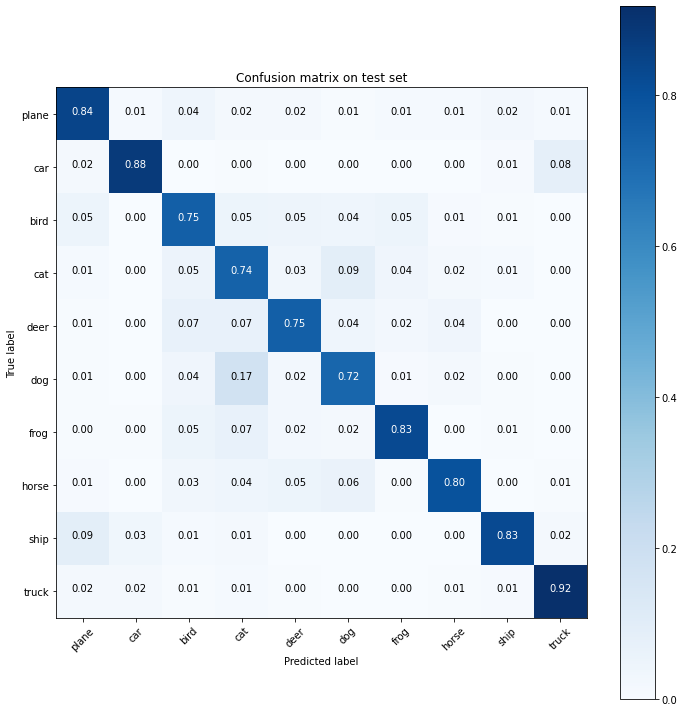

In [ ]:
# Source: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,title='Confusion matrix on test set')

From the confusion matrix above we can see that the model did a really good job - it's a test set, really ;)

The most common mistake was classifying a dog as a cat, so let's find a few examples of such mistakes.

## Inspection of the most common mistake of the network

### Why were so many dogs classified as a cat?

In [ ]:
true_class = actual_labels.tolist()
pred_class = test_preds.argmax(dim=1).tolist()
dogs_classified_as_cats = []
for i in range(len(true_class)):
  if true_class[i] == 5.0: # dog
    if pred_class[i] == 3: # cat
      dogs_classified_as_cats += [i]
print(f'Found {len(dogs_classified_as_cats)} such mistakes')

def show_dog_classified_as_cat(mistake_number):
  img, label = test_set[dogs_classified_as_cats[mistake_number]]
  plt.title('Dog classified as a cat')
  plt.axis("off")
  plt.imshow(img.cpu().permute(1, 2, 0))
  plt.show()

Found 175 such mistakes


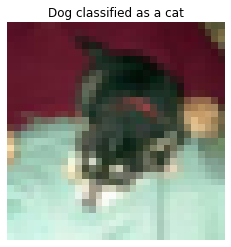

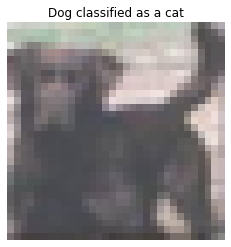

In [ ]:
show_dog_classified_as_cat(0)
show_dog_classified_as_cat(19)

As we can see, in some cases a human would classify a photo correcly, however...

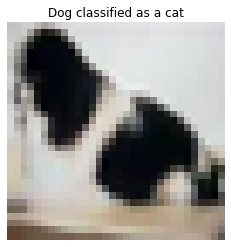

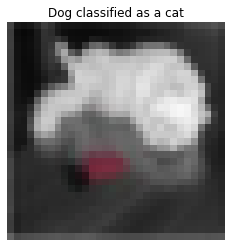

In [ ]:
show_dog_classified_as_cat(52)
show_dog_classified_as_cat(101)

There are cases where a photo is... harder to classify. Low resolution makes it hard to distinguish and find any characteristic features. We may call such mistakes made by the model as acceptable.

# t-SNE of input image representations by the ResNet18

Model used here is the model trained with Dropout regularization 0.2 with accuracy of around 0.8 on test set.

Source: [github](https://github.com/pslinge144/medium/blob/master/zero-shot_learning_1/Representation%20Learning%20-%20Part%202%20-%20CIFAR-10%20Representations.ipynb)

First, I swap last layer (linear 512 -> 10) with identity layer (effectively removing it's effect on network's output).

In [17]:
network.linear

Linear(in_features=512, out_features=10, bias=True)

In [18]:
network.linear = nn.Identity(512)

In [63]:
network.linear

Identity()

Then, I get all predictions on a new model (a model without the last layer). For the sake of simplicity, only 10% of data was used.

In [22]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds
test_loader_small = torch.utils.data.DataLoader(test_set_small, batch_size = 100,num_workers=2)
test_preds = get_all_preds(network, test_loader_small)

Next, the unusual thing I do is first pass all prediction vectors of length 512 through PCA to 50 dimensions and then through t-SNE. Finally t-SNE predictions are scaled to 0-1.

In [64]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
features = test_preds

pca = PCA(n_components=50)
pca.fit(features)
pca_features = pca.transform(features)

tsne = TSNE().fit_transform(pca_features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


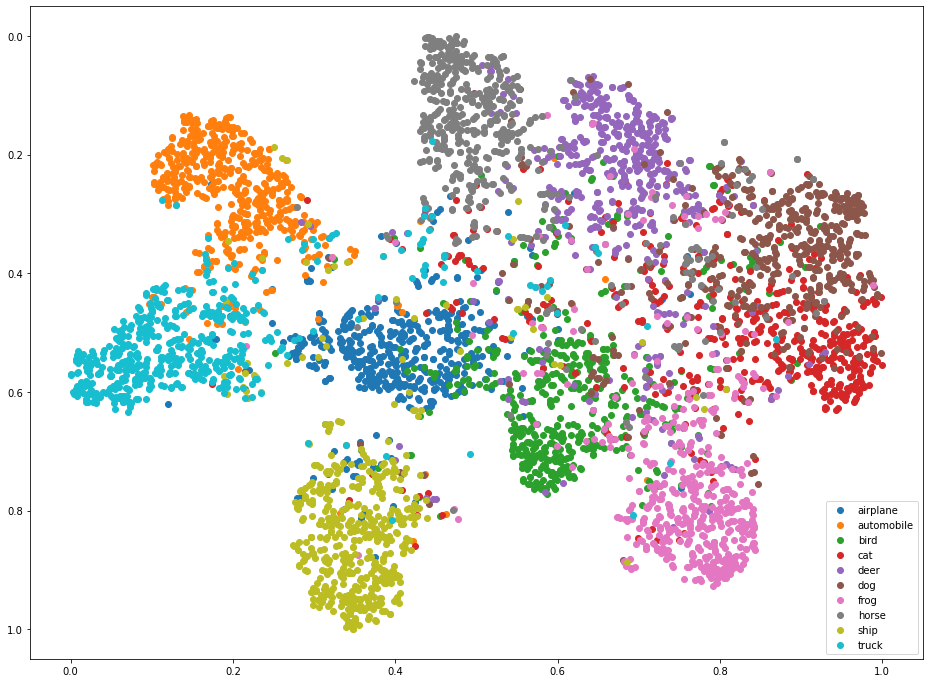

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,12))

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test = np.array([i[1] for i in test_set_small]) # real labels
for i in range(len(classes)):
    y_i = y_test == i
    plt.scatter(tx[y_i[:]], ty[y_i[:]], label=classes[i])
plt.legend(loc=4)
plt.gca().invert_yaxis()
plt.show()

t-SNE representation of 10% of test data represented by the last layer of ResNet18 network.

Vector representation of each input image of size 32x32x3=3072 has length 512. PCA has reduced it to 50 dimensions and finally T-SNE has reduced it to 2 dimensions. Color is responsible for different classes.

Here, color red and brown overlap the most, with reflects the confusion matrix above.

# Summary

## Training

First, on 10% of all data, later on 100% of CIFAR 10.

### Hyperparameter search

Tested models were ResNet18 and ResNet34. Both were trained and tested on first 10% of train and test CIFAR10 data.

Results were similar - both networks stopped improving accuracy on test set at around 0.5 after 5 epochs.

### Training on all data

Resnet18 turned out to be sufficient for CIFAR10 dataset. What's more, bigger networks such as ResNet34 take much more time to train with similar results => it is not always worth time and computing resources to start with too big architectures.

Results obtained after training:
- ResNet18: 10 epochs and got around 0.8 accuracy 
- ResNet34: 5 epochs and got around  accuracy

## Dropout regularization

Next, Dropout was added to ResNet18 with 0.2 parameter, with hope to increase accuracy score on test set with same trainig parameters as before. However, it seems that the new model didn't get much better results. Despite that, it was exported to Drive and used in later analysis.

## Confusion Matrix + analysis of the most common mistake

The most common mistake was classifying a dog as a cat. After further inspection it turned out that due to low resolution some mistakes were hard if possible to correct, however there are some pictures which would be correctly classified by a human.

## t-SNE

Final plot shows image representations as vectors before the last layer after being transformed to 2D space using PCA and t-SNE. Some colors (classes) are more separated than others whereas dogs and cats (brown and red) are not.

